In [25]:
using JuMP  
using Ipopt 
using Plots
using Plots.PlotMeasures

Augmented Problem


In [26]:
mutable struct Direct
    t; t1;t2;t3; s1;s2;s3;s4; b1;b2;b3;b4; v1;v2;v3;v4; x1;x2;x3;x4; u1;u2;u3;u4
end

In [27]:
function example(x0=[1, 5*exp(-4), 0]; solution=[], nsteps=200, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-6)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",500)

    N  = nsteps     # Grid size

    @variables(sys, begin
    0 ≤   s1[1:N+1]   ≤ 1         
    0 ≤   s2[1:N+1]   ≤ 1     
    0 ≤   s3[1:N+1]   ≤ 1 
    0 ≤   s4[1:N+1]   ≤ 1 

        # s33[1:N+1]   # augmented state for the equality state constraint penalization   

        b1[1:N+1]         
        b2[1:N+1]         
        b3[1:N+1]        
        b4[1:N+1]        

        v1[1:N+1]         
        v2[1:N+1]         
        v3[1:N+1]        
        v4[1:N+1]        

        x1[1:N+1]      #time variable non-autonomous case --> autonomous case    
        x2[1:N+1]      #time variable non-autonomous case --> autonomous case    
        x3[1:N+1]      #time variable non-autonomous case --> autonomous case 
        x4[1:N+1]      #time variable non-autonomous case --> autonomous case  

     0. ≤ u1[1:N+1] ≤ 1.    # Control
     0. ≤ u2[1:N+1] ≤ 1.    # Control
     0. ≤ u3[1:N+1] ≤ 1.    # Control
     0. ≤ u4[1:N+1] ≤ 1.    # Control

     0. ≤ t1 ≤ 1.      # first transverse crossing
     0. ≤ t2 ≤ 1.      # second transverse crossing (arrival at the inferface)  
     0. ≤ t3 ≤ 1.      # third transverse crossing (leaving the inferface)    
    end)

       for i in 1:N+1
   #     set_start_value(s33[i], 0.0);
        set_start_value(u1[i] , 0.0);
        set_start_value(u2[i] , 1.0);
        set_start_value(u3[i] , 0.2);
        set_start_value(u4[i] , 0.0);
    end
    

    
    Δt  = 1/(N+1) ; 
    k1  = 2.1     ;
    k2  = 5.      ;
    r   = 25.     ;
    V_T = 0.083   ;
    sh  = 0.2     ;
    sw  = 0.3     ;
    ϵ   = 1e-10   ;

    # Objective
    #@NLobjective(sys, Min, -b4[N+1] + (1/ϵ)*s33[N+1])
    @NLobjective(sys,  Max, b4[N+1])

    # Boundary constraints
    @constraints(sys, begin
        con_s10, s1[1]      == x0[1]
        con_s20, s2[1]      == s1[N+1]
        con_s30, s3[1]      == s2[N+1]
        con_s40, s4[1]      == s3[N+1]

        #con_s330, s33[1]    == 0.

        con_s100,  s1[N+1]  ==  0.7
        con_s200,  s2[N+1]  ==  0.7
        con_s300,  s3[1]    ==  0.7


        con_b10, b1[1]   == x0[2]
        con_b20, b2[1]   == b1[N+1]
        con_b30, b3[1]   == b2[N+1]
        con_b40, b4[1]   == b3[N+1]

        con_v10, v1[1]   == x0[3]
        con_v20, v2[1]   == v1[N+1]
        con_v30, v3[1]   == v2[N+1]
        con_v40, v4[1]   == v3[N+1]
        con_v4f, v4[N+1] == V_T

        con_x10, x1[1]   == 0.
        con_x20, x2[1]   == x1[N+1]
        con_x30, x3[1]   == x2[N+1]
        con_x40, x4[1]   == x3[N+1]

        con_t1,     t2 >= t1   
        con_t2,     t3 >= t2  
        

    end)

    # Dynamics
    @NLexpression(sys, ds1[j = 1:N+1],      t1*(-k1*((x1[j])^4*1                    + (1-(x1[j])^4)*(s1[j]-sh)/(1-sh)) + k1*k2*u1[j]))
    @NLexpression(sys, ds2[j = 1:N+1], (t2-t1)*(-k1*((x2[j])^4*(s2[j]-sw)/(0.7-sw)  + (1-(x2[j])^4)*(s2[j]-sh)/(1-sh)) + k1*k2*u2[j]))
    @NLexpression(sys, ds3[j = 1:N+1], (t3-t2)*(-k1*((x3[j])^4*1                    + (1-(x3[j])^4)*(s3[j]-sh)/(1-sh)) + k1*((x3[j])^4*1   +(1-(x3[j])^4)*(s3[j]-sh)/(1-sh))))
    @NLexpression(sys, ds4[j = 1:N+1],  (1-t3)*(-k1*((x4[j])^4*(s4[j]-sw)/(0.7-sw)  + (1-(x4[j])^4)*(s4[j]-sh)/(1-sh)) + k1*k2*u4[j]))

    #@NLexpression(sys, ds33[j = 1:N+1],  (s3[j]-0.7)^2)

    @NLexpression(sys, db1[j = 1:N+1],      t1*(r*(x1[j])^4*b1[j]*(1-b1[j])*1))
    @NLexpression(sys, db2[j = 1:N+1], (t2-t1)*(r*(x2[j])^4*b2[j]*(1-b2[j])*(s2[j]-sw)/(0.7-sw)))
    @NLexpression(sys, db3[j = 1:N+1], (t3-t2)*(r*(x3[j])^4*b3[j]*(1-b3[j])*1))
    @NLexpression(sys, db4[j = 1:N+1],  (1-t3)*(r*(x4[j])^4*b4[j]*(1-b4[j])*(s4[j]-sw)/(0.7-sw)))

    @NLexpression(sys, dv1[j = 1:N+1],      t1*u1[j])
    @NLexpression(sys, dv2[j = 1:N+1], (t2-t1)*u2[j])
    @NLexpression(sys, dv3[j = 1:N+1], (t3-t2)*(1/k2)*((x3[j])^4*1   +(1-(x3[j])^4)*(s3[j]-sh)/(1-sh)))
    @NLexpression(sys, dv4[j = 1:N+1],  (1-t3)*u4[j])

    @NLexpression(sys, dx1[j = 1:N+1],    t1)
    @NLexpression(sys, dx2[j = 1:N+1], t2-t1)
    @NLexpression(sys, dx3[j = 1:N+1], t3-t2)
    @NLexpression(sys, dx4[j = 1:N+1],  1-t3)

    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_ds1[j=1:N], s1[j+1] == s1[j] + 0.5 * Δt * (ds1[j+1] + ds1[j])
        con_ds2[j=1:N], s2[j+1] == s2[j] + 0.5 * Δt * (ds2[j+1] + ds2[j])
        con_ds3[j=1:N], s3[j+1] == s3[j] + 0.5 * Δt * (ds3[j+1] + ds3[j])
        con_ds4[j=1:N], s4[j+1] == s4[j] + 0.5 * Δt * (ds4[j+1] + ds4[j])

        #con_ds33[j=1:N], s33[j+1] == s33[j] + 0.5 * Δt * (ds33[j+1] + ds33[j])

        con_db1[j=1:N], b1[j+1] == b1[j] + 0.5 * Δt * (db1[j+1] + db1[j])
        con_db2[j=1:N], b2[j+1] == b2[j] + 0.5 * Δt * (db2[j+1] + db2[j])
        con_db3[j=1:N], b3[j+1] == b3[j] + 0.5 * Δt * (db3[j+1] + db3[j])
        con_db4[j=1:N], b4[j+1] == b4[j] + 0.5 * Δt * (db4[j+1] + db4[j])

        con_dv1[j=1:N], v1[j+1] == v1[j] + 0.5 * Δt * (dv1[j+1] + dv1[j])
        con_dv2[j=1:N], v2[j+1] == v2[j] + 0.5 * Δt * (dv2[j+1] + dv2[j])
        con_dv3[j=1:N], v3[j+1] == v3[j] + 0.5 * Δt * (dv3[j+1] + dv3[j])
        con_dv4[j=1:N], v4[j+1] == v4[j] + 0.5 * Δt * (dv4[j+1] + dv4[j])

        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dx3[j=1:N], x3[j+1] == x3[j] + 0.5 * Δt * (dx3[j+1] + dx3[j])
        con_dx4[j=1:N], x4[j+1] == x4[j] + 0.5 * Δt * (dx4[j+1] + dx4[j])
    end);

    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    s1 = value.(s1)[:]
    s2 = value.(s2)[:]
    s3 = value.(s3)[:]
    s4 = value.(s4)[:]

    b1 = value.(b1)[:]
    b2 = value.(b2)[:]
    b3 = value.(b3)[:]
    b4 = value.(b4)[:]

    v1 = value.(v1)[:]
    v2 = value.(v2)[:]
    v3 = value.(v3)[:]
    v4 = value.(v4)[:]

    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    x3 = value.(x3)[:]
    x4 = value.(x4)[:]

    u1 = value.(u1)[:]
    u2 = value.(u2)[:]
    u3 = value.(u3)[:]
    u4 = value.(u4)[:]

    t  = (0:N) * value.(Δt)

    t1 = value.(t1)
    t2 = value.(t2)
    t3 = value.(t3)




    return Direct(t, t1,t2,t3, s1,s2,s3,s4, b1,b2,b3,b4, v1,v2,v3,v4, x1,x2,x3,x4, u1,u2,u3,u4)
    
end;

In [28]:
# Resolution
direct_sol = example();

Solving...
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    18432
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:    38400

Total number of variables............................:     4023
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1611
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3220
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.90e-01 1.00e+00  -1.0 0.00e+00    -  0.00e+0

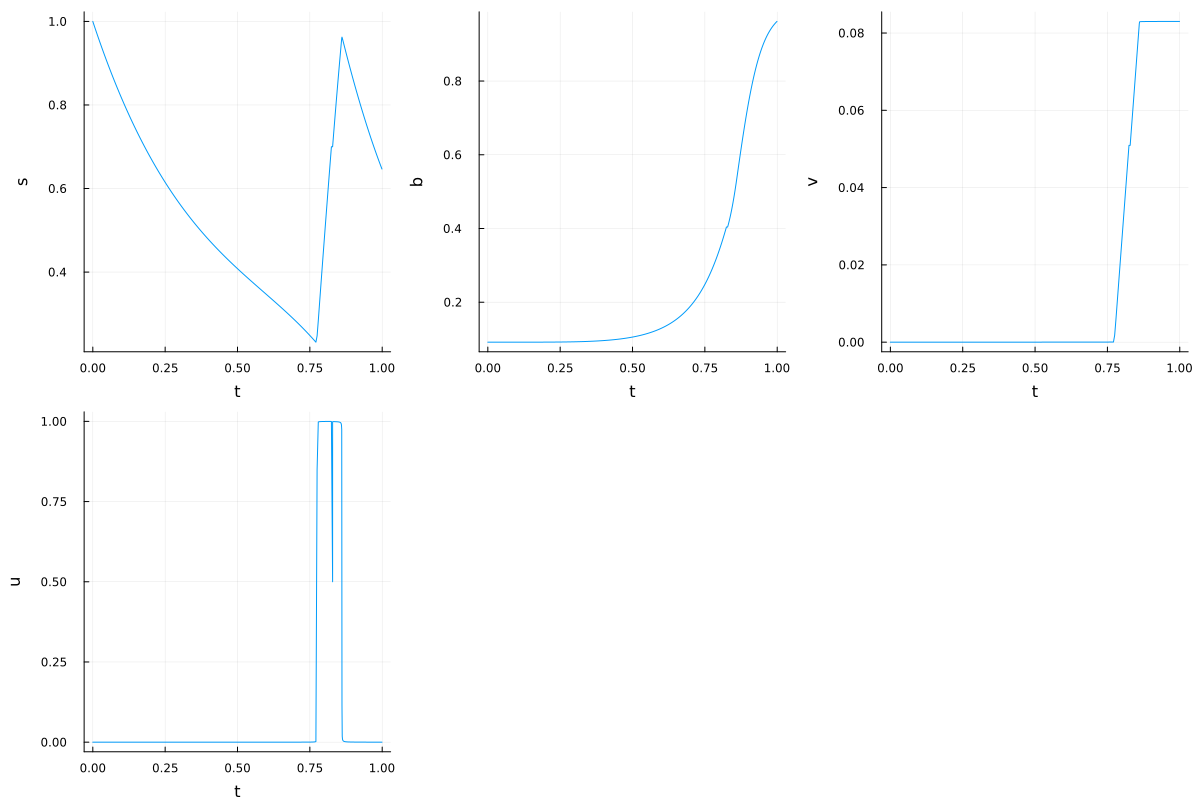

In [29]:
t  = direct_sol.t
t1 = direct_sol.t1
t2 = direct_sol.t2
t3 = direct_sol.t3


tX1   = t .* t1
tX2   = t1*ones(length(t)) + t .* (t2-t1)
tX3   = t2*ones(length(t)) + t .* (t3-t2);
tX4   = t3*ones(length(t)) + t .* (1-t3);
t_all = vcat(tX1, tX2, tX3, tX4);
     

s1 = direct_sol.s1
s2 = direct_sol.s2
s3 = direct_sol.s3
s4 = direct_sol.s4
s  = vcat(s1, s2, s3, s4)

b1 = direct_sol.b1
b2 = direct_sol.b2
b3 = direct_sol.b3
b4 = direct_sol.b4
b  = vcat(b1, b2, b3, b4)

v1 = direct_sol.v1
v2 = direct_sol.v2
v3 = direct_sol.v3
v4 = direct_sol.v4
v  = vcat(v1, v2, v3, v4)

u1 = direct_sol.u1
u2 = direct_sol.u2
u3 = direct_sol.u3
u4 = direct_sol.u4
u  = vcat(u1, u2, u3, u4)


a= plot(t_all, s,  xlabel = "t", ylabel = "s",  legend = false)
b= plot(t_all, b,  xlabel = "t", ylabel = "b",  legend = false)
c= plot(t_all, v,  xlabel = "t", ylabel = "v",  legend = false)
d= plot(t_all, u,  xlabel = "t", ylabel = "u",  legend = false)

plot(a,b,c,d, layout = (2,3), size=(1200,800), left_margin=5mm)

In [30]:
savefig("file.pdf")

"c:\\Users\\Anas\\Desktop\\control-loss-main\\Irrigation\\file.pdf"

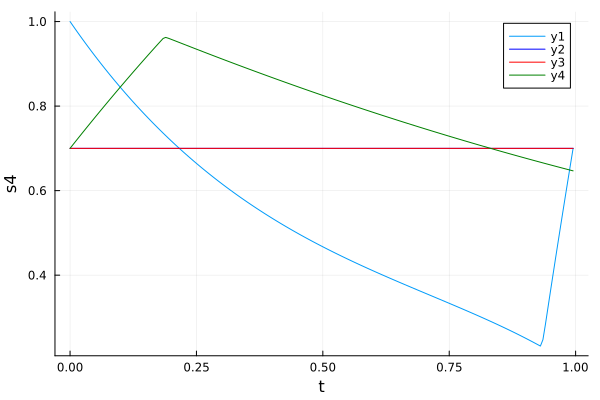

In [31]:
plot(t, s1,  xlabel = "t", ylabel = "s1")
plot!(t, s2,  xlabel = "t", ylabel = "s2",color="blue")
plot!(t, s3,  xlabel = "t", ylabel = "s3",color="red")
plot!(t, s4,  xlabel = "t", ylabel = "s4",color="green")


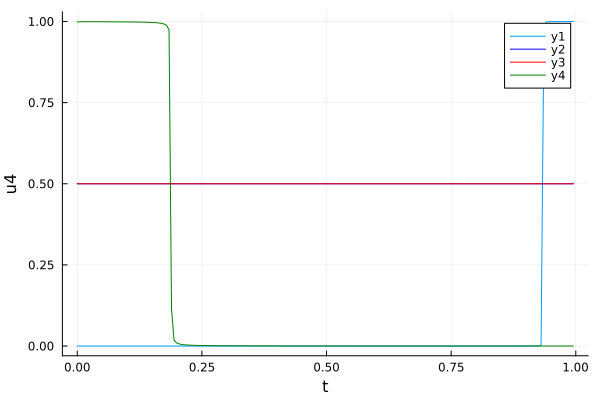

In [32]:
plot(t, u1,  xlabel = "t", ylabel = "u1")
plot!(t, u2,  xlabel = "t", ylabel = "u2",color="blue")
plot!(t, u3,  xlabel = "t", ylabel = "u3",color="red")
plot!(t, u4,  xlabel = "t", ylabel = "u4",color="green")